In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
shapefile_path = 'data/hydrobasins_lvl6/hybas_as_lev06_v1c.shp'
shapes = gpd.read_file(shapefile_path)

In [3]:
def get_precip_data_for_year(data_path, shapes):
    dataset = xr.open_dataset(data_path)
    
    sums = []
    
    for index, shape in shapes.iterrows():
        # Extract the geometry
        geom = shape.geometry

        # Select the data from the NetCDF file using the geometry
        # because \nearest\ method is used, even if there is no data
        # , it will calculate an average for data nearest to it
        # this makes it appear like there is data for areas where there is none (e.g., in Japan).
        # TODO : needs to label whether a shape is part of tibetan plateau or not
        data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method='nearest')
        # data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method=None)

        # Calculate the sum of the data
        # data_sum = data.sum()
        data_sum = data.sum()['tp'].values

        # Append the sum to the list
        sums.append(data_sum)
        
    return sums


In [4]:
years = np.arange(1984, 2022, 1)

final_data_set = pd.DataFrame()

for year in years:
    precip = get_precip_data_for_year(f'data/precip/{year}/data.nc', shapes=shapes)
    year_df = pd.DataFrame()
    year_df['precip'] = precip
    year_df['precip'] = year_df['precip'].astype(np.float64)
    year_df['year'] = year
    final_data_set = pd.concat([final_data_set, year_df])
    
final_data_set.head()

,precip,year
0,0.143784,1984
1,0.143784,1984
2,0.143784,1984
3,0.143784,1984
4,0.143784,1984


In [5]:
# Calculate the centroid of each shape and add a marker to the map
shapes['centroid_lon'] = shapes.apply(lambda row: row['geometry'].centroid.x, axis=1)
shapes['centroid_lat'] = shapes.apply(lambda row: row['geometry'].centroid.y, axis=1)


In [6]:
final_data_set = final_data_set.join(shapes).sort_values(by=['year', 'SORT'])
final_data_set = gpd.GeoDataFrame(final_data_set)

# bounding box from precip data
xmin = 45
xmax = 107
ymin = 24
ymax = 68

final_data_set = final_data_set.cx[xmin:xmax, ymin:ymax]


final_data_set.describe()
final_data_set.head()

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_lon,centroid_lat
447,1.206194,1984,4060631960,4060629690,4060007850,4060007850,1356.8,1356.8,28426.8,51783.5,432270,0,0,2,448,"POLYGON ((108.86667 34.43750, 108.88138 34.438...",107.535213,34.395430
451,0.880377,1984,4060611660,4060631880,4060007850,4060007850,1527.2,1527.2,4221.8,4222.0,432262,0,0,4,452,"POLYGON ((106.58750 35.12083, 106.58807 35.127...",107.389148,35.047425
453,0.778580,1984,4060606120,4060611300,4060007850,4060007850,1552.4,1552.4,14418.8,14418.8,432264,0,0,4,454,"POLYGON ((107.41667 35.30000, 107.40174 35.300...",106.924689,35.716825
462,0.695534,1984,4060583100,4060606020,4060007850,4060007850,1649.8,1649.8,5961.4,10598.4,432267,0,0,3,463,"POLYGON ((107.67917 36.41667, 107.67981 36.410...",107.294046,36.419078
472,0.778336,1984,4060625230,4060631960,4060007850,4060007850,1753.2,1753.2,10713.7,10713.7,432290,0,0,2,473,"POLYGON ((106.29583 35.29167, 106.30662 35.291...",105.759122,35.404014


In [7]:
lake_df = pd.read_csv('data/gsw_reduced/lake_data.csv')
lake_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/gsw_reduced/lake_data.csv'

In [ ]:
df = final_data_set.merge(lake_df, on=['HYBAS_ID', 'year'])

In [ ]:
df.plot('precip', cmap='Spectral')


(0.0, 1.0)

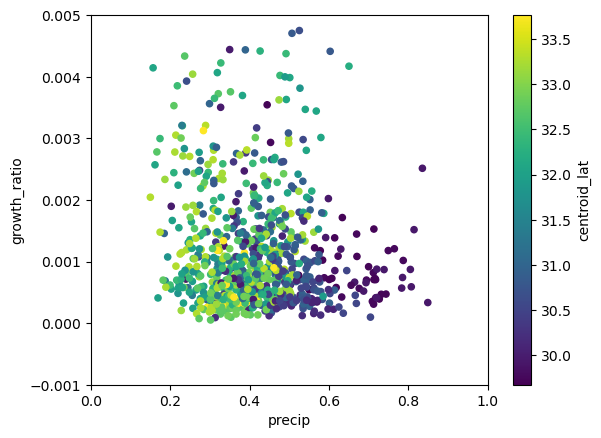

In [10]:
ax = df.plot.scatter('precip', 'growth_ratio', c='centroid_lat')
ax.set_ylim(-0.001, 0.005)
ax.set_xlim(0, 1)

/var/folders/20/67zvnfrd4qn0q8029j2qbpqw0000gn/T/ipykernel_58270/862849438.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df.groupby('year').sum()


<Axes: xlabel='year'>

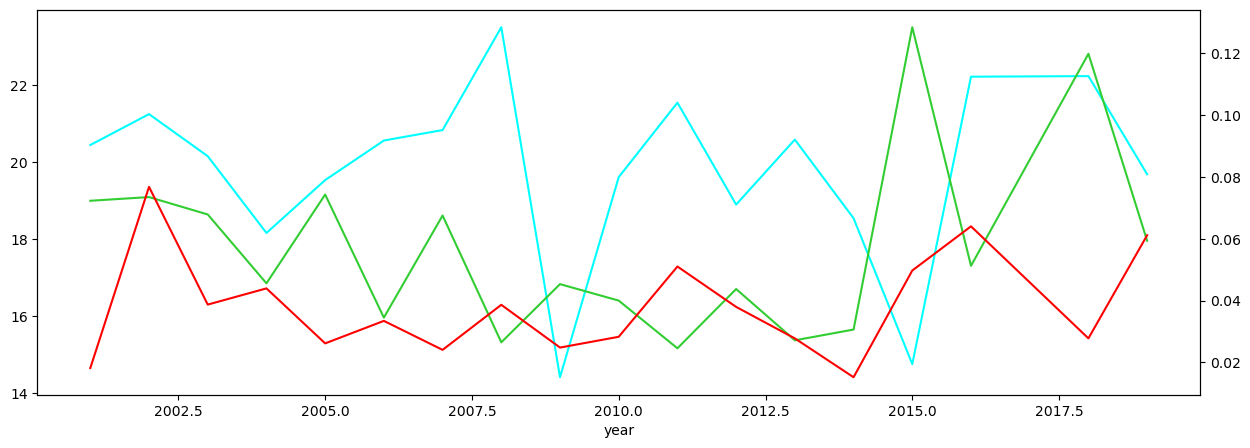

In [19]:
sums = df.groupby('year').sum()

# sums.cumsum().precip.plot()
fig, ax = plt.subplots(figsize=(15, 5))
sums.precip.plot(ax=ax, color='cyan')
ax2 = ax.twinx()
sums.growth_ratio.plot(ax=ax2, color='limegreen')
sums.decline_ratio.plot(ax=ax2, color='red')

In [30]:
df['all'].apply(lambda row: (row * 30 * 30)/1e3**2)

0      26222.465601
1       8590.709072
2      23388.881467
3       6659.974726
4       4481.223614
           ...     
805     8653.118838
806     2023.341642
807     5263.154216
808     6636.734954
809     1155.784984
Name: all, Length: 810, dtype: float64

In [27]:
df.columns

Index(['precip', 'year', 'HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS',
       'DIST_SINK', 'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO',
       'COAST', 'ORDER', 'SORT', 'geometry', 'centroid_lon', 'centroid_lat',
       'Unnamed: 0', 'lake_growth', 'lake_decline', 'all', 'growth_ratio',
       'decline_ratio'],
      dtype='object')

<Axes: xlabel='SUB_AREA', ylabel='all'>

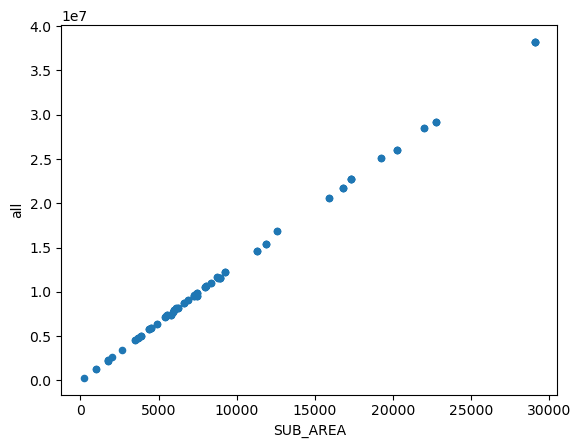

In [34]:
ddf[['SUB_AREA', 'all']].drop_duplicates().plot.scatter('SUB_AREA', 'all')

In [64]:
df.describe()

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,...,ORDER,SORT,centroid_lon,centroid_lat,Unnamed: 0,lake_growth,lake_decline,all,growth_ratio,decline_ratio
count,810.000000,810.000000,8.100000e+02,8.100000e+02,8.100000e+02,8.100000e+02,810.000000,810.000000,810.000000,810.000000,...,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,8.100000e+02,810.000000,810.000000
mean,0.440566,2009.611111,4.060242e+09,1.082870e+09,4.060046e+09,4.060046e+09,727.742222,727.742222,8669.368889,9086.175556,...,1.244444,2058.377778,84.956416,31.693644,22.000000,15282.362653,-10227.700392,1.133737e+07,0.001274,0.000848
std,0.204300,5.369246,3.145634e+05,1.796846e+09,1.095291e+04,1.095291e+04,1228.154745,1228.154745,6288.856985,6212.626434,...,0.523372,410.750470,2.426316,1.207289,12.995197,21483.373902,13822.264185,8.163468e+06,0.001397,0.001070
min,0.149781,2001.000000,4.060050e+09,0.000000e+00,4.060025e+09,4.060025e+09,0.000000,0.000000,220.800000,996.700000,...,1.000000,1234.000000,81.224312,29.674561,0.000000,109.000000,-109729.862745,2.837804e+05,0.000043,0.000021
25%,0.326761,2005.000000,4.060052e+09,0.000000e+00,4.060034e+09,4.060034e+09,0.000000,0.000000,4875.100000,5405.900000,...,1.000000,1652.000000,82.944441,30.657746,11.000000,3500.744118,-12389.030392,6.417233e+06,0.000509,0.000362
50%,0.414921,2009.500000,4.060053e+09,0.000000e+00,4.060051e+09,4.060051e+09,0.000000,0.000000,7250.500000,7390.300000,...,1.000000,2248.000000,84.609595,31.914118,22.000000,7824.503922,-5167.394118,9.517855e+06,0.000864,0.000630
75%,0.496116,2014.000000,4.060690e+09,4.060689e+09,4.060053e+09,4.060053e+09,1612.200000,1612.200000,9223.000000,11293.300000,...,1.000000,2342.000000,87.143602,32.742962,33.000000,18048.179412,-2383.000000,1.228056e+07,0.001537,0.000983
max,1.826507,2019.000000,4.060799e+09,4.060807e+09,4.060056e+09,4.060056e+09,3138.300000,3138.300000,29078.100000,29078.100000,...,3.000000,2442.000000,90.002616,33.765231,44.000000,155429.317647,-73.000000,3.822362e+07,0.022393,0.022206


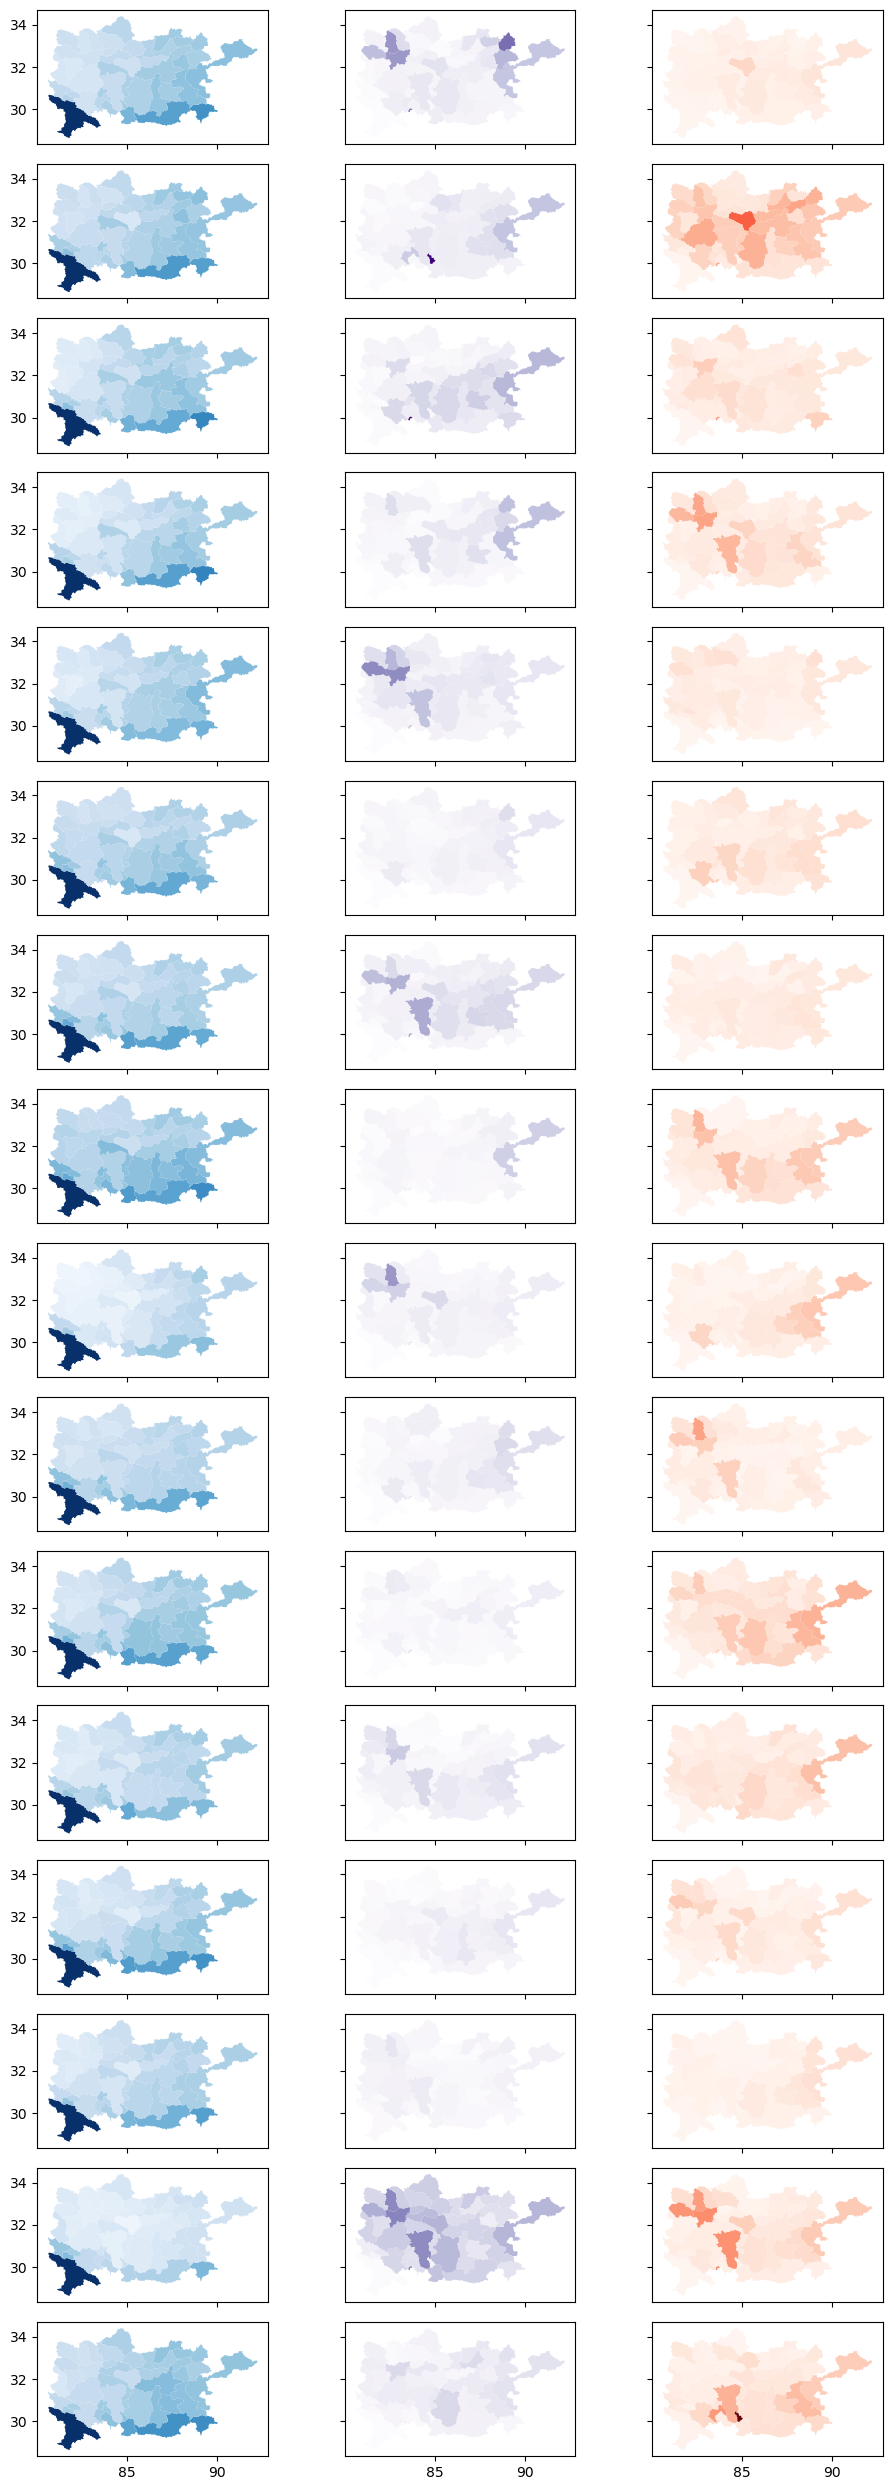

In [65]:
fig, ax = plt.subplots(16, 3, figsize=(10, 25), sharex=True, sharey=True)
# ax = ax.flatten()
for year in df.year.unique()[:-2]:
    # print(year, year-2001)
    df[df.year==year].plot('precip', ax=ax[year-2001][0], cmap='Blues', vmin=0.1, vmax=1.2)
    df[df.year==year].plot('growth_ratio', ax=ax[year-2001][1], cmap='Purples', vmin=1e-4, vmax=1e-2)
    df[df.year==year].plot('decline_ratio', ax=ax[year-2001][2], cmap='Reds', vmin=1e-4, vmax=1e-2)

fig.tight_layout()

In [52]:
ax.shape

(17, 3)

In [43]:
year

2021

In [55]:
df.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2018, 2019])